In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import class_weight
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

In [6]:
base_dir = "dataset"

In [7]:
img_height = 224
img_width = 224
channels = 3
batch_size = 64

In [8]:
df = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,  
    image_size=(img_height, img_width), 
    batch_size=batch_size
)

class_names = df.class_names

class_counts = {class_name: 0 for class_name in class_names}

for images, labels in df:
    for label in labels.numpy():  
        class_counts[class_names[int(label)]] += 1  

print(class_counts)

Found 6156 files belonging to 6 classes.
{'blast': 1015, 'blight': 1011, 'brown spot': 1013, 'healthy': 1015, 'hispa': 1086, 'tungro': 1016}


In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = "categorical"
  )

Found 6156 files belonging to 6 classes.
Using 4925 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = "categorical")

Found 6156 files belonging to 6 classes.
Using 1231 files for validation.


In [11]:
labels = []
for _, y in train_ds:
    label_indices = np.argmax(y.numpy(), axis=1)
    labels.extend(label_indices)
labels = np.array(labels)

unique_classes = np.unique(labels)

class_weights = class_weight.compute_class_weight(
    'balanced',                        
    classes=unique_classes,            
    y=labels                          
)

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weight_dict)

{0: np.float64(0.9889558232931727), 1: np.float64(1.0222083852220838), 2: np.float64(1.0083947583947583), 3: np.float64(1.0286131996658312), 4: np.float64(0.9327651515151515), 5: np.float64(1.0260416666666667)}


In [12]:
data_dir = base_dir  
class_names = sorted(os.listdir(data_dir))
print(class_names)

['blast', 'blight', 'brown spot', 'healthy', 'hispa', 'tungro']


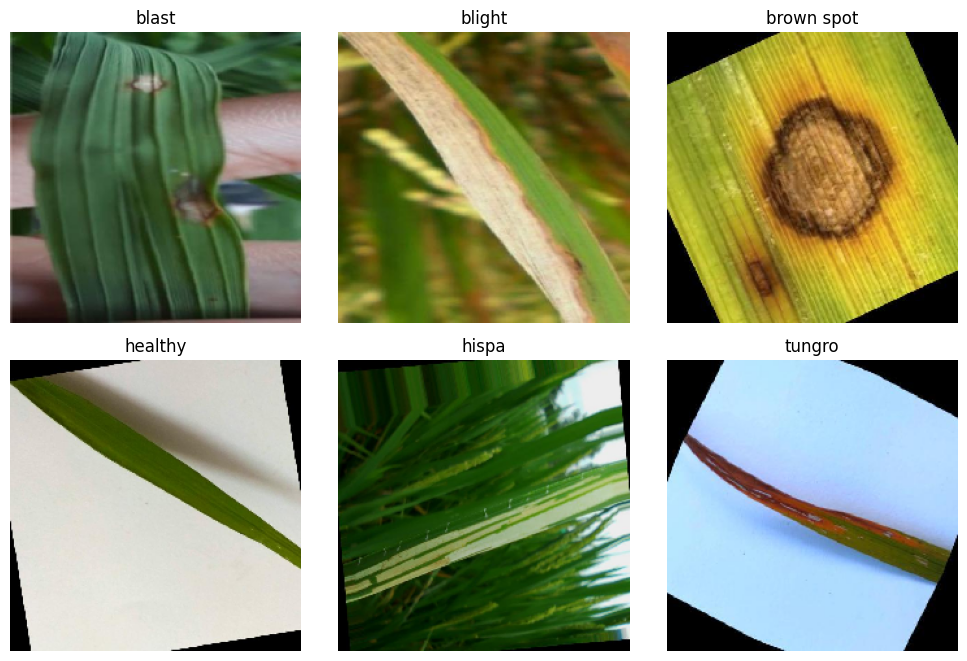

In [13]:
from tensorflow.keras.preprocessing import image
import random
class_names = os.listdir(data_dir)

plt.figure(figsize=(10, 10))

for i, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    
    if os.path.isdir(class_dir):  
        
        image_files = os.listdir(class_dir)
        
        if image_files:
           
            img_path = os.path.join(class_dir, random.choice(image_files))         
            img = image.load_img(img_path, target_size=(224, 224))
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')

plt.tight_layout()
plt.show()

**Model Building**

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',kernel_initializer = "he_uniform", padding = "valid", input_shape=(img_width, img_height, channels)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer = "he_uniform", padding = "same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer = "he_uniform", padding = "same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer = "he_uniform", padding = "same"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer = "he_uniform"),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(512, activation = "relu", kernel_initializer = "he_uniform"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(512, activation = "relu", kernel_initializer = "he_uniform"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax', kernel_initializer="glorot_uniform")
    
    ])
model.summary()

c:\Users\My ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 111, 111, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 55, 55, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 55, 55, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 27, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 27, 27, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    22,151,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 23,336,134 (89.02 MB)

 Trainable params: 23,333,638 (89.01 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [15]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

In [17]:
initial_epochs = 15
history = model.fit(train_ds,
                    callbacks = [early_stop, lr_scheduler],
                    class_weight=class_weight_dict,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - accuracy: 0.3637 - loss: 1.6269 - val_accuracy: 0.3176 - val_loss: 1.9253 - learning_rate: 1.0000e-04
Epoch 2/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step - accuracy: 0.5793 - loss: 1.0689 - val_accuracy: 0.6962 - val_loss: 0.8176 - learning_rate: 1.0000e-04
Epoch 3/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 254s 3s/step - accuracy: 0.6731 - loss: 0.8657 - val_accuracy: 0.7660 - val_loss: 0.6235 - learning_rate: 1.0000e-04
Epoch 4/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.7352 - loss: 0.7378 - val_accuracy: 0.8188 - val_loss: 0.5125 - learning_rate: 1.0000e-04
Epoch 5/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.7840 - loss: 0.5959 - val_accuracy: 0.8375 - val_loss: 0.4382 - learning_rate: 1.0000e-04
Epoch 6/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.8215 - loss: 0.4917 - val_accuracy: 0.8879 - val_loss: 0.3540 - learning_rate: 1.0000e-04
Epoch 7/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.8600 

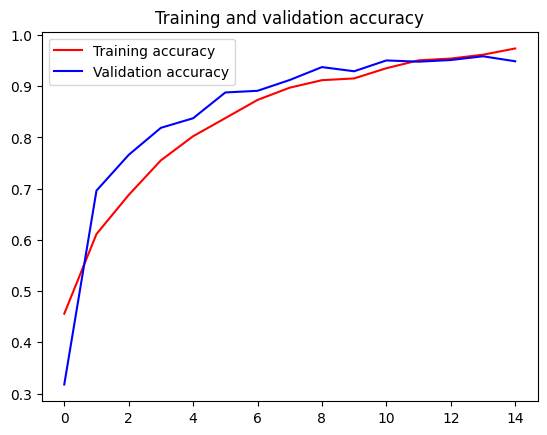

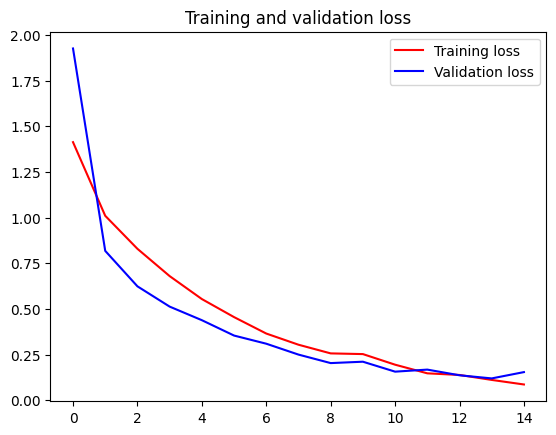

<Figure size 640x480 with 0 Axes>

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
model.save('SmartPaddy_8.0_.h5')  

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


img_path = r'Rice Leaf Disease Images\Bacterialblight\BACTERAILBLIGHT3_007.jpg'


model = load_model('SmartPaddy_7.0_.h5')


img = image.load_img(img_path, target_size=(img_width, img_height))


x = image.img_to_array(img)


x = np.expand_dims(x, axis=0)


images = np.vstack([x])
classes = model.predict(images)

class_names = class_names


predicted_class = class_names[np.argmax(classes)]  
predicted_prob = np.max(classes)  

print(f"Predicted Class: {predicted_class}")
print(f"Probability: {predicted_prob:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
Predicted Class: blight
Probability: 0.51


**Transfer Learning**

In [37]:
InceptionV3 = applications.InceptionV3(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')

In [ ]:
for layer in InceptionV3.layers[:-10]:
    layer.trainable = False
    
x = InceptionV3.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)   
x = BatchNormalization()(x)           
x = Dropout(0.3)(x)                    
x = Dense(256, activation='relu')(x)   
x = BatchNormalization()(x)            
x = Dropout(0.2)(x)                    


prediction = Dense(6, activation='softmax')(x)  


model = Model(inputs=InceptionV3.input, outputs=prediction)


In [39]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

In [42]:
initial_epochs = 30
history = model.fit(train_ds,
                    callbacks = [early_stop, lr_scheduler],
                    class_weight=class_weight_dict,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.4548 - loss: 1.5886 - val_accuracy: 0.4086 - val_loss: 1.4729 - learning_rate: 1.0000e-04
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.6555 - loss: 0.9445 - val_accuracy: 0.6247 - val_loss: 0.9955 - learning_rate: 1.0000e-04
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.7219 - loss: 0.7734 - val_accuracy: 0.7628 - val_loss: 0.7438 - learning_rate: 1.0000e-04
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 215s 3s/step - accuracy: 0.7782 - loss: 0.6223 - val_accuracy: 0.7799 - val_loss: 0.6675 - learning_rate: 1.0000e-04
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.8047 - loss: 0.5473 - val_accuracy: 0.8156 - val_loss: 0.5691 - learning_rate: 1.0000e-04
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - accuracy: 0.8352 - loss: 0.4548 - val_accuracy: 0.8489 - val_loss: 0.4715 - learning_rate: 1.0000e-04
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 334s 4s/step - accuracy: 0.8724 

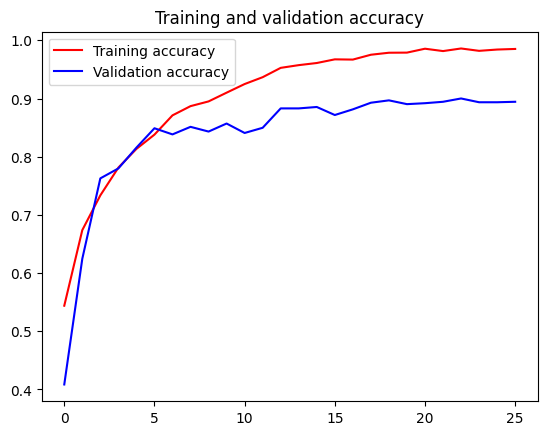

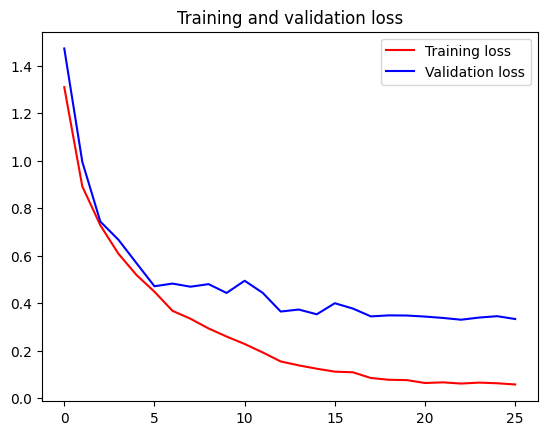

<Figure size 640x480 with 0 Axes>

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [44]:
model.save('SmartPaddy_8.0_.h5')  

In [60]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


img_path = r'Rice Leaf Disease Images\Blast\BLAST1_029.jpg'

model = load_model('SmartPaddy_8.0_.h5')


img = image.load_img(img_path, target_size=(img_width, img_height))


x = image.img_to_array(img)


x = np.expand_dims(x, axis=0)


images = np.vstack([x])
classes = model.predict(images)

class_names = ['blast', 'blight', 'brown spot', 'healthy', 'hispa', 'tungro']


predicted_class = class_names[np.argmax(classes)]  
predicted_prob = np.max(classes)  

print(f"Predicted Class: {predicted_class}")
print(f"Probability: {predicted_prob:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: blast
Probability: 1.00


In [63]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


with open('Model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\MYASUS~1\AppData\Local\Temp\tmpmw40h_ee\assets


INFO:tensorflow:Assets written to: C:\Users\MYASUS~1\AppData\Local\Temp\tmpmw40h_ee\assets


Saved artifact at 'C:\Users\MYASUS~1\AppData\Local\Temp\tmpmw40h_ee'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2055280402192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2055280401040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2055280400272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2055280398352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2055280401424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2055280399696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2055280404496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2055280404688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2055280399888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2055280406032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2